In [15]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def calculate_entropy(comments):
    word_counts = {}
    total_words = 0
    for comment in comments:
        if isinstance(comment, str):
            words = comment.lower().split()
            for word in words:
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
                total_words += 1
    entropy = 0
    for word, count in word_counts.items():
        probability = count / total_words
        entropy -= probability * math.log2(probability)
    return entropy

def calculate_entropies_by_chunk(file_path, column_name, chunk_size=50):
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
        comments = df[column_name].dropna().tolist()
        entropies = []

        for i in range(0, len(comments), chunk_size):
            chunk = comments[i : i + chunk_size]

            if len(chunk) == chunk_size:
              entropy = calculate_entropy(chunk)
              entropies.append(entropy)

        return entropies

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None

    except KeyError:
        print(f"Error: Column '{column_name}' not found in the file.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [2]:
file_path = 'tt1g.xlsx'
column_name = 'Comment'
chunk_size = 10

entropies = calculate_entropies_by_chunk(file_path, column_name, chunk_size)

if entropies:
  print(f"Entropies for chunks of {chunk_size} comments in '{file_path}':")
  for i, entropy in enumerate(entropies):
      print(f"Chunk {i + 1}: {entropy}")

Entropies for chunks of 10 comments in 'tt1g.xlsx':
Chunk 1: 5.594999260557344
Chunk 2: 5.713233110104681
Chunk 3: 5.69456995612296
Chunk 4: 5.68201599528136
Chunk 5: 5.386794896215866
Chunk 6: 5.691571533283429
Chunk 7: 5.529054267930633
Chunk 8: 5.686146588249914
Chunk 9: 5.609183719779185


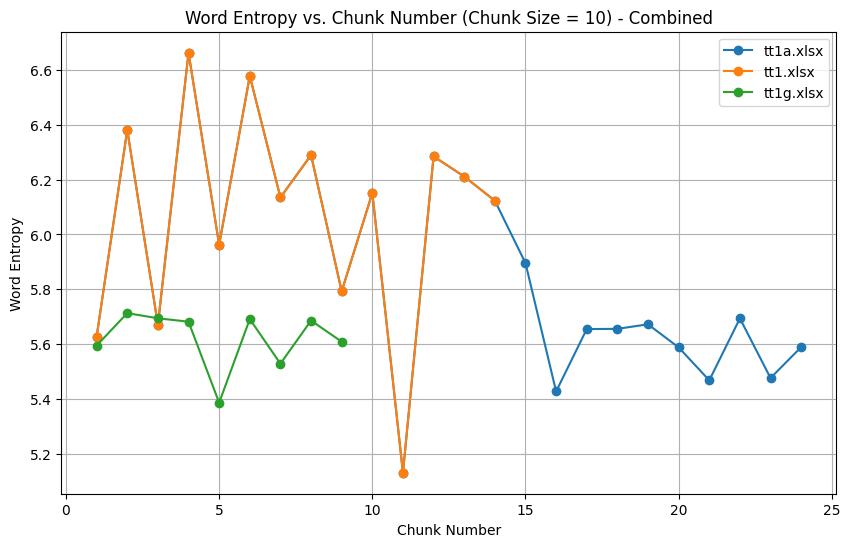

In [3]:
def plot_entropy_vs_chunks_combined(file_paths, column_name, chunk_size=10):
    """Plots entropy vs. chunk number for multiple files in a combined plot."""
    plt.figure(figsize=(10, 6))
    for file_path in file_paths:
        entropies = calculate_entropies_by_chunk(file_path, column_name, chunk_size)
        if entropies:
            chunk_numbers = range(1, len(entropies) + 1)
            plt.plot(chunk_numbers, entropies, marker='o', label=file_path)

    plt.xlabel("Chunk Number")
    plt.ylabel("Word Entropy")
    plt.title(f"Word Entropy vs. Chunk Number (Chunk Size = {chunk_size}) - Combined")
    plt.legend()
    plt.grid(True)
    plt.show()


file_paths = ['tt1a.xlsx', 'tt1.xlsx', 'tt1g.xlsx']
column_name = 'Comment'
plot_entropy_vs_chunks_combined(file_paths, column_name)

In [4]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def plot_entropy_with_lowess(file_path, column_name='Comment', chunk_size=10):
    """
    Calculates and plots entropy with LOWESS smoothing.
    """
    entropies = calculate_entropies_by_chunk(file_path, column_name, chunk_size)
    if entropies:
        chunk_numbers = range(1, len(entropies) + 1)


        smoothed_entropies = lowess(entropies, chunk_numbers, frac=0.3)

        plt.plot(chunk_numbers, entropies, marker='o', linestyle='-', label='Actual Entropy')
        plt.plot(smoothed_entropies[:, 0], smoothed_entropies[:, 1], marker='x', linestyle='--', label='LOWESS Smoothed Entropy')

        plt.xlabel("Chunk Number")
        plt.ylabel("Word Entropy")
        plt.title(f"Word Entropy vs. Chunk Number ({file_path}) - with LOWESS Smoothing")
        plt.legend()
        plt.grid(True)
        plt.show()

column_name = 'Comment'

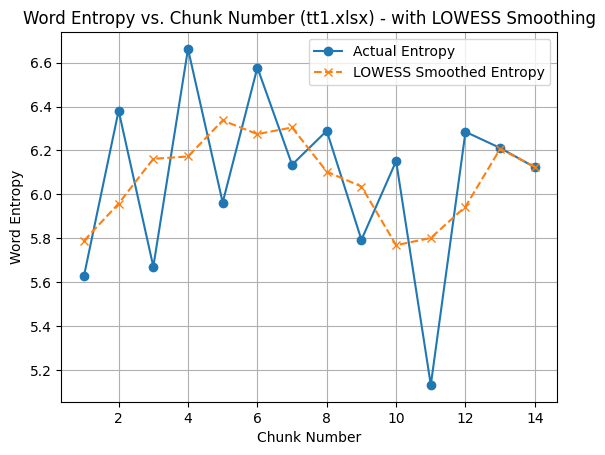

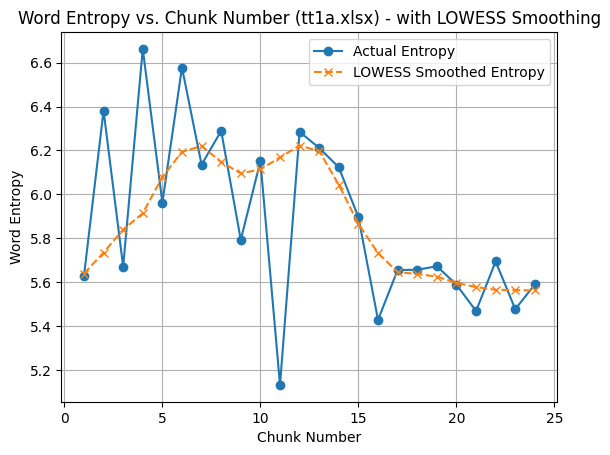

In [5]:
file_paths = ['tt1.xlsx', 'tt1a.xlsx']

for file_path in file_paths:
    plot_entropy_with_lowess(file_path, column_name)

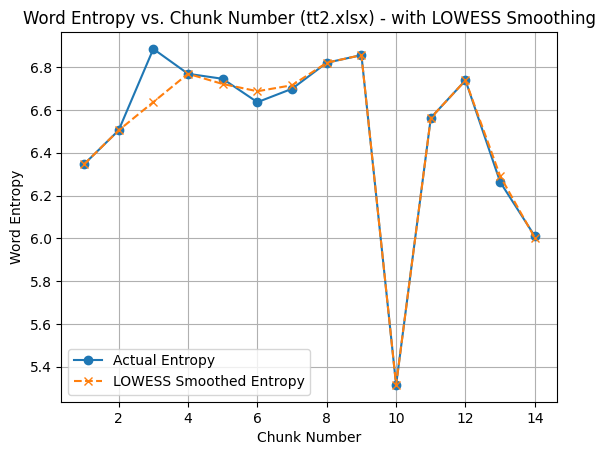

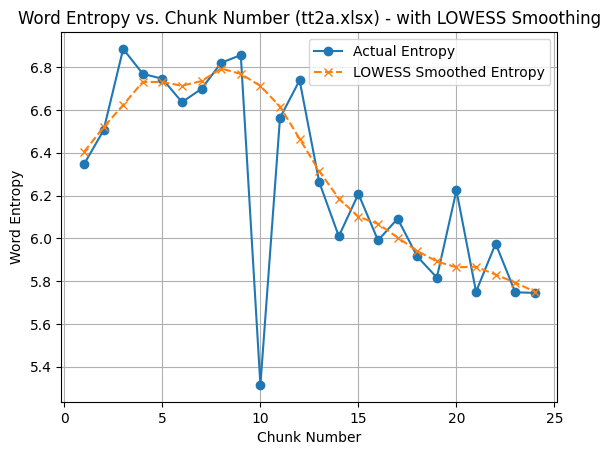

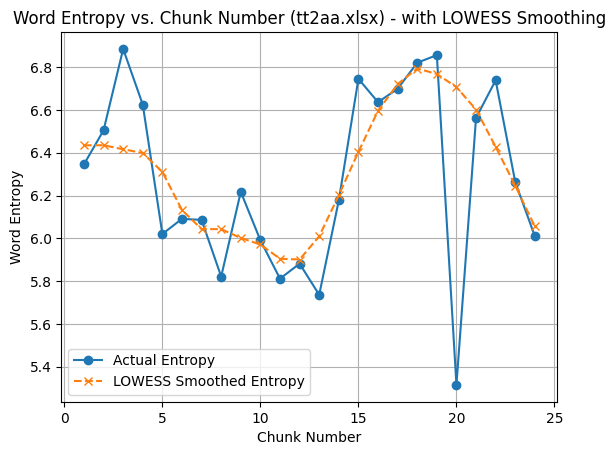

In [6]:
file_paths = ['tt2.xlsx', 'tt2a.xlsx', 'tt2aa.xlsx']

for file_path in file_paths:
    plot_entropy_with_lowess(file_path, column_name)

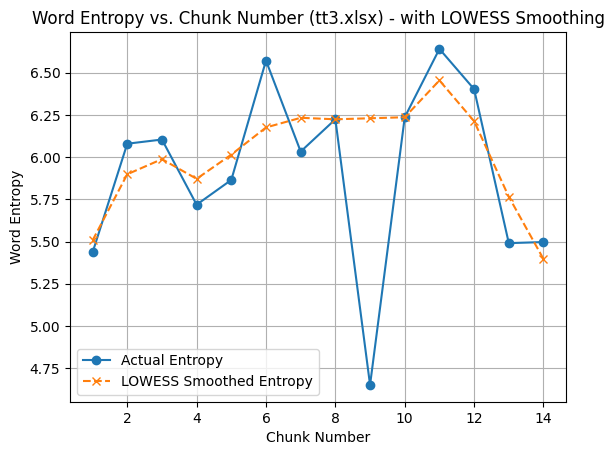

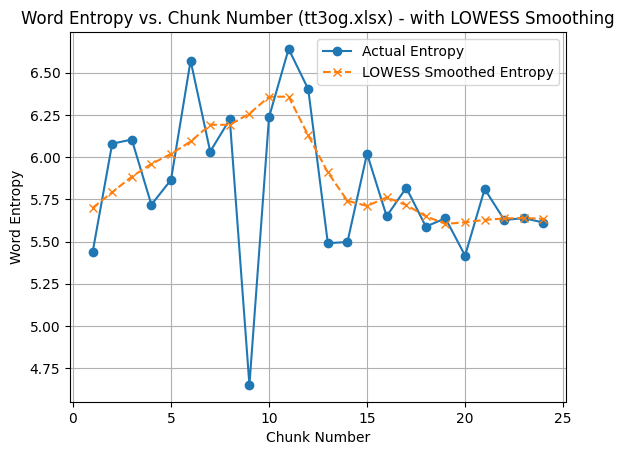

In [7]:
file_paths = ['tt3.xlsx', 'tt3og.xlsx']

for file_path in file_paths:
    plot_entropy_with_lowess(file_path, column_name)

In [8]:
def detect_stable_low_entropy(
    file_path,
    column_name,
    chunk_size=10,
    drop_percent=0.02,  # насколько должна упасть энтропия от среднего
    min_consecutive=4   # сколько подряд низких чанков считается "аномалией"
):
    entropies = calculate_entropies_by_chunk(file_path, column_name, chunk_size)
    if not entropies:
        return "Ошибка при подсчёте энтропий."

    mean_entropy = np.mean(entropies)
    threshold = mean_entropy * (1 - drop_percent)

    # ищем последовательности подряд идущих энтропий ниже порога
    low_streak = 0
    total_streaks = 0

    for e in entropies:
        if e < threshold:
            low_streak += 1
            if low_streak == min_consecutive:
                total_streaks += 1  # зафиксировали один подозрительный участок
        else:
            low_streak = 0  # сброс

    if total_streaks > 0:
        return (
            f"Обнаружены участки с последовательно низкой энтропией "
            f"(ниже {threshold:.2f}, {drop_percent*100:.0f}% от среднего). "
            f"Количество таких участков: {total_streaks}. Возможна генерация."
        )
    else:
        return "Подозрительно стабильных просадок энтропии не найдено."

In [9]:
def detect_stable_low_entropy(
    file_path,
    column_name,
    chunk_size=10,
    drop_percent=0.02,     # Насколько должна упасть энтропия от среднего
    min_consecutive=4,     # Сколько подряд низких чанков считается "аномалией"
    neighbor_diff_threshold=0.75  # Порог для фильтрации выбросов
):
    entropies = calculate_entropies_by_chunk(file_path, column_name, chunk_size)
    if not entropies:
        return "Ошибка при подсчёте энтропий."

    # --- Шаг 1: очищаем выбросы при расчёте средней энтропии ---
    cleaned = []
    for i in range(len(entropies)):
        if i == 0 or i == len(entropies) - 1:
            cleaned.append(entropies[i])
        else:
            prev, curr, next_ = entropies[i - 1], entropies[i], entropies[i + 1]
            if abs(curr - prev) > neighbor_diff_threshold and abs(curr - next_) > neighbor_diff_threshold:
                continue  # выброс
            cleaned.append(curr)

    if not cleaned:
        return "После очистки не осталось данных для анализа."

    mean_entropy = np.mean(cleaned)
    threshold = mean_entropy * (1 - drop_percent)

    # --- Шаг 2: ищем участки с последовательно низкой энтропией ---
    low_streak = 0
    total_streaks = 0

    for e in entropies:
        if e < threshold:
            low_streak += 1
            if low_streak == min_consecutive:
                total_streaks += 1
        else:
            low_streak = 0  # сброс

    if total_streaks > 0:
        return (
            f"Обнаружены участки с последовательно низкой энтропией "
            f"(ниже {threshold:.2f}, {drop_percent*100:.0f}% от очищенной средней). "
            f"Количество таких участков: {total_streaks}. Возможна генерация."
        )
    else:
        return "Подозрительно стабильных просадок энтропии не найдено."

In [10]:
def detect_stable_low_entropy(
    file_path,
    column_name,
    chunk_size=10,
    drop_percent=0.02,        # Насколько должна упасть энтропия от средней
    min_consecutive=4,        # Сколько подряд низких чанков считается "аномалией"
    neighbor_diff_threshold=0.75  # Порог отклонения от соседей для исключения выбросов
):
    entropies = calculate_entropies_by_chunk(file_path, column_name, chunk_size)
    if not entropies:
        return "Ошибка при подсчёте энтропий."

    raw_mean = np.mean(entropies)

    # --- Очистка выбросов (одиночных скачков) ---
    cleaned = []
    for i in range(len(entropies)):
        if i == 0 or i == len(entropies) - 1:
            cleaned.append(entropies[i])
        else:
            prev, curr, next_ = entropies[i - 1], entropies[i], entropies[i + 1]
            if abs(curr - prev) > neighbor_diff_threshold and abs(curr - next_) > neighbor_diff_threshold:
                continue  # одиночный выброс
            cleaned.append(curr)

    if not cleaned:
        return "После очистки не осталось данных для анализа."

    cleaned_mean = np.mean(cleaned)
    threshold = cleaned_mean * (1 - drop_percent)

    # --- Поиск стабильных просадок ---
    low_streak = 0
    total_streaks = 0
    detected_sequences = []  # Список участков с просадками

    current_sequence = []

    for idx, e in enumerate(entropies):
        if e < threshold:
            low_streak += 1
            current_sequence.append((idx + 1, e))  # +1 чтобы отображался как Chunk 1, 2, 3...
            if low_streak == min_consecutive:
                total_streaks += 1
                detected_sequences.append(current_sequence.copy())
        else:
            low_streak = 0
            current_sequence = []

    # --- Вывод ---
    print(f"Средняя энтропия (без фильтрации): {raw_mean:.4f}")
    print(f"Средняя энтропия (после фильтрации выбросов): {cleaned_mean:.4f}")
    print(f"Порог для определения низкой энтропии: {threshold:.4f}\n")

    if total_streaks > 0:
        print(f"Обнаружены участки с {min_consecutive} или более подряд низкими энтропиями:")
        for i, seq in enumerate(detected_sequences, 1):
            print(f"  Участок {i}:")
            for chunk_num, value in seq:
                print(f"    Chunk {chunk_num}: {value:.4f}")
        return (
            f"\n⚠️ Найдено {total_streaks} подозрительных участка. Возможна генерация комментариев."
        )
    else:
        return "✔️ Подозрительно стабильных просадок энтропии не найдено."

In [11]:
def detect_stable_low_entropy(
    file_path,
    column_name,
    chunk_size=10,
    drop_percent=0.02,        # How much should the entropy fall from the average
    min_consecutive=3,        # How many consecutive low chunks are considered "anomaly"
    neighbor_window=2,        # How many neighbors to look at on the left/right
    neighbor_diff_threshold=0.75  # How strong should the difference from the neighbors be
):
    entropies = calculate_entropies_by_chunk(file_path, column_name, chunk_size)
    if not entropies:
        return "Ошибка при подсчёте энтропий."

    raw_mean = np.mean(entropies)
    outlier_indices = []

    for i in range(len(entropies)):
        left = max(0, i - neighbor_window)
        right = min(len(entropies), i + neighbor_window + 1)
        neighbor_values = entropies[left:i] + entropies[i+1:right]

        if neighbor_values:
            neighbor_avg = np.mean(neighbor_values)
            if abs(entropies[i] - neighbor_avg) > neighbor_diff_threshold:
                outlier_indices.append(i)



    cleaned_entropies = [
        val for idx, val in enumerate(entropies) if idx not in outlier_indices
    ]

    if not cleaned_entropies:
        return "После очистки не осталось данных для анализа."

    cleaned_mean = np.mean(cleaned_entropies)
    threshold = cleaned_mean * (1 - drop_percent)



    low_streak = 0
    total_streaks = 0
    detected_sequences = []
    current_sequence = []

    for idx, e in enumerate(entropies):
        if e < threshold:
            low_streak += 1
            current_sequence.append((idx + 1, e))
            if low_streak == min_consecutive:
                total_streaks += 1
                detected_sequences.append(current_sequence.copy())
        else:
            low_streak = 0
            current_sequence = []



    print(f"Средняя энтропия (все): {raw_mean:.4f}")
    print(f"Средняя энтропия (без выбросов): {cleaned_mean:.4f}")
    print(f"Порог низкой энтропии: {threshold:.4f}\n")

    if total_streaks > 0:
        print(f"Обнаружены участки с подряд {min_consecutive}+ низкими энтропиями:")
        for i, seq in enumerate(detected_sequences, 1):
            print(f"  Участок {i}:")
            for chunk_num, value in seq:
                print(f"    Chunk {chunk_num}: {value:.4f}")
        return f"\n⚠️ Найдено {total_streaks} подозрительных участка. Возможна генерация."
    else:
        return "✔️ Подозрительно стабильных просадок энтропии не найдено."


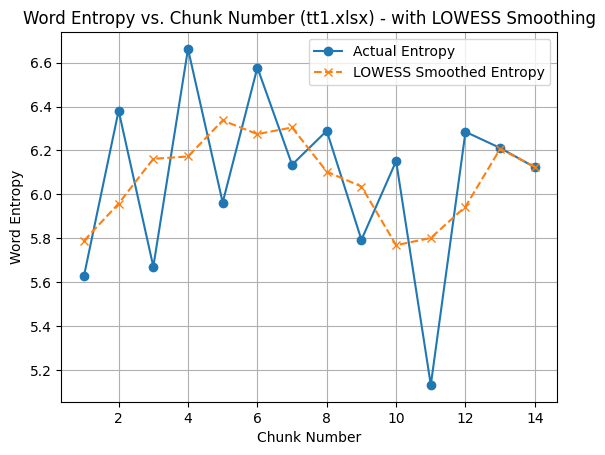

Средняя энтропия (все): 6.0714
Средняя энтропия (без выбросов): 6.1437
Порог низкой энтропии: 6.0208

Вердикт: ✔️ Подозрительно стабильных просадок энтропии не найдено.


In [16]:
file_path = 'tt1.xlsx'
plot_entropy_with_lowess(file_path)
verdict = detect_stable_low_entropy(file_path, column_name='Comment')
print("Вердикт:", verdict)

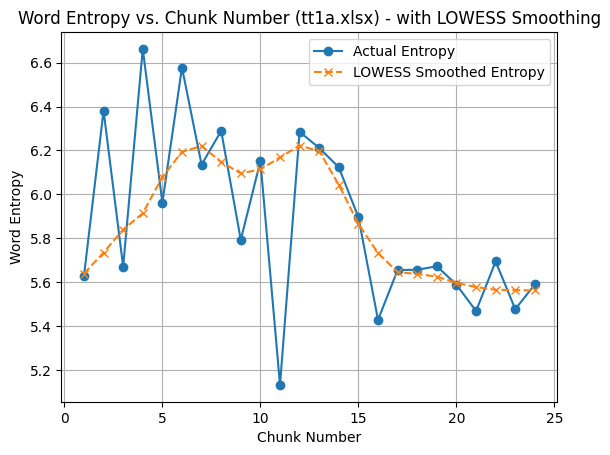

Средняя энтропия (все): 5.8802
Средняя энтропия (без выбросов): 5.9127
Порог низкой энтропии: 5.7944

Обнаружены участки с подряд 3+ низкими энтропиями:
  Участок 1:
    Chunk 16: 5.4277
    Chunk 17: 5.6551
    Chunk 18: 5.6561
Вердикт: 
⚠️ Найдено 1 подозрительных участка. Возможна генерация.


In [17]:
file_path = 'tt1a.xlsx'
plot_entropy_with_lowess(file_path)
verdict = detect_stable_low_entropy(file_path, column_name='Comment')
print("Вердикт:", verdict)

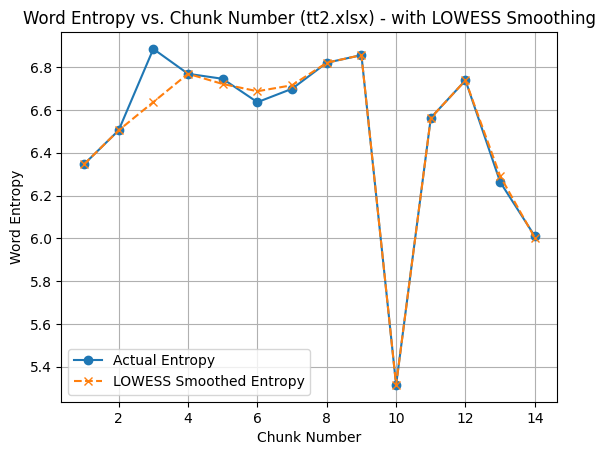

Средняя энтропия (все): 6.5107
Средняя энтропия (без выбросов): 6.6026
Порог низкой энтропии: 6.4706

Вердикт: ✔️ Подозрительно стабильных просадок энтропии не найдено.


In [18]:
file_path = 'tt2.xlsx'
plot_entropy_with_lowess(file_path)
verdict = detect_stable_low_entropy(file_path, column_name='Comment')
print("Вердикт:", verdict)

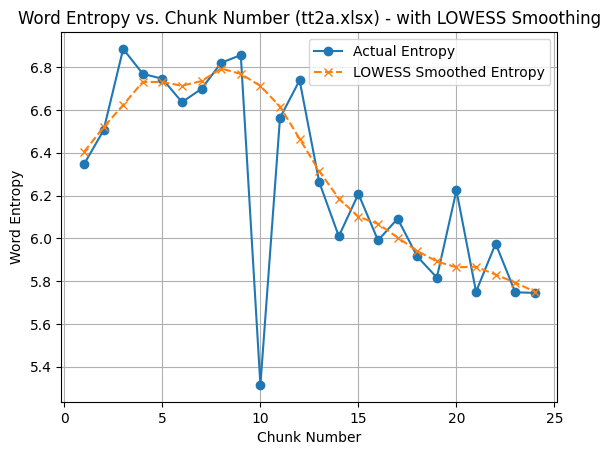

Средняя энтропия (все): 6.2756
Средняя энтропия (без выбросов): 6.3173
Порог низкой энтропии: 6.1910

Обнаружены участки с подряд 3+ низкими энтропиями:
  Участок 1:
    Chunk 16: 5.9905
    Chunk 17: 6.0917
    Chunk 18: 5.9154
  Участок 2:
    Chunk 21: 5.7505
    Chunk 22: 5.9755
    Chunk 23: 5.7478
Вердикт: 
⚠️ Найдено 2 подозрительных участка. Возможна генерация.


In [19]:
file_path = 'tt2a.xlsx'
plot_entropy_with_lowess(file_path)
verdict = detect_stable_low_entropy(file_path, column_name='Comment')
print("Вердикт:", verdict)

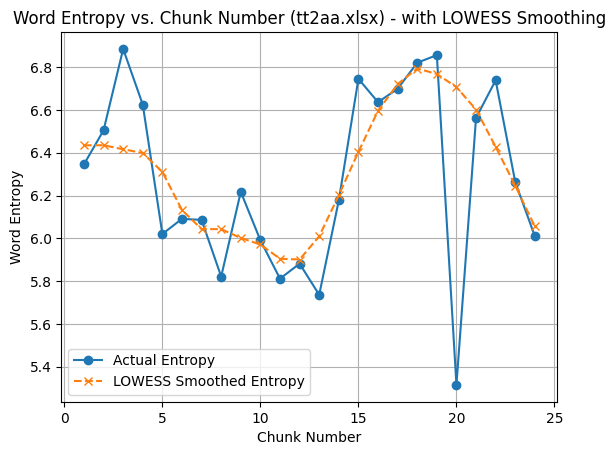

Средняя энтропия (все): 6.2850
Средняя энтропия (без выбросов): 6.3271
Порог низкой энтропии: 6.2006

Обнаружены участки с подряд 3+ низкими энтропиями:
  Участок 1:
    Chunk 5: 6.0203
    Chunk 6: 6.0911
    Chunk 7: 6.0860
  Участок 2:
    Chunk 10: 5.9909
    Chunk 11: 5.8116
    Chunk 12: 5.8814
Вердикт: 
⚠️ Найдено 2 подозрительных участка. Возможна генерация.


In [22]:
file_path = 'tt2aa.xlsx'
plot_entropy_with_lowess(file_path)
verdict = detect_stable_low_entropy(file_path, column_name='Comment')
print("Вердикт:", verdict)

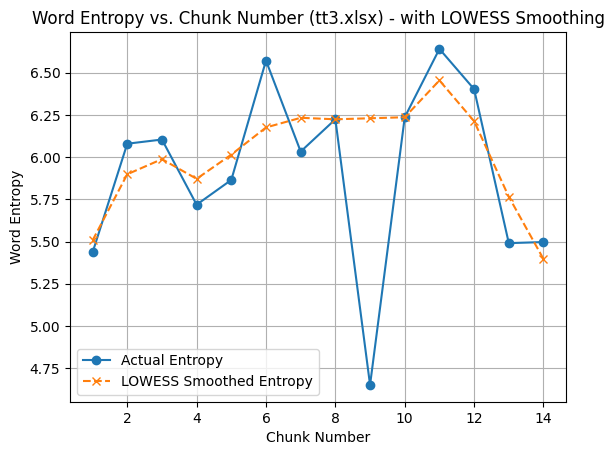

Средняя энтропия (все): 5.9246
Средняя энтропия (без выбросов): 5.9711
Порог низкой энтропии: 5.8517

Вердикт: ✔️ Подозрительно стабильных просадок энтропии не найдено.


In [20]:
file_path = 'tt3.xlsx'
plot_entropy_with_lowess(file_path)
verdict = detect_stable_low_entropy(file_path, column_name='Comment')
print("Вердикт:", verdict)

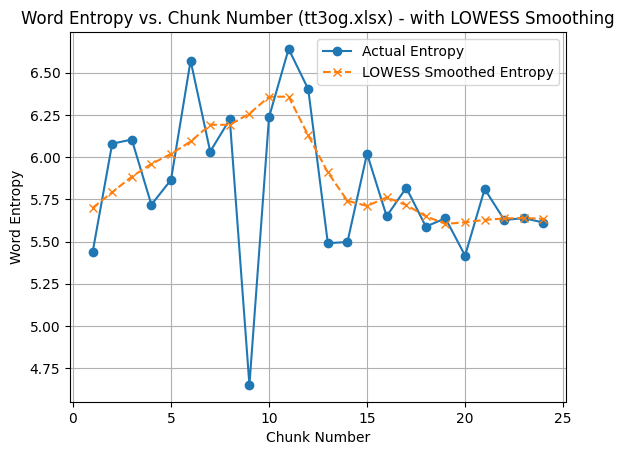

Средняя энтропия (все): 5.8235
Средняя энтропия (без выбросов): 5.8397
Порог низкой энтропии: 5.7229

Обнаружены участки с подряд 3+ низкими энтропиями:
  Участок 1:
    Chunk 18: 5.5885
    Chunk 19: 5.6376
    Chunk 20: 5.4167
  Участок 2:
    Chunk 22: 5.6276
    Chunk 23: 5.6383
    Chunk 24: 5.6123
Вердикт: 
⚠️ Найдено 2 подозрительных участка. Возможна генерация.


In [21]:
file_path = 'tt3og.xlsx'
plot_entropy_with_lowess(file_path)
verdict = detect_stable_low_entropy(file_path, column_name='Comment')
print("Вердикт:", verdict)